In [1]:
%load_ext autoreload
%autoreload 2

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from src.data_utils import *
from src.lstmattn import LSTMAttentionModel
from src.training_utils import *

### Load segmented data

In [2]:
# define data directory
data_dir = '../data/'

In [3]:
# load data
data = load_data(data_dir)

# split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data)

Number of samples: 13388
--------------------
Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)
--------------------
X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Achilles Tendon Force Across Training Samples'}, xlabel='Percent Normalized Stance (%)', ylabel='Muscle Force (N)'>)

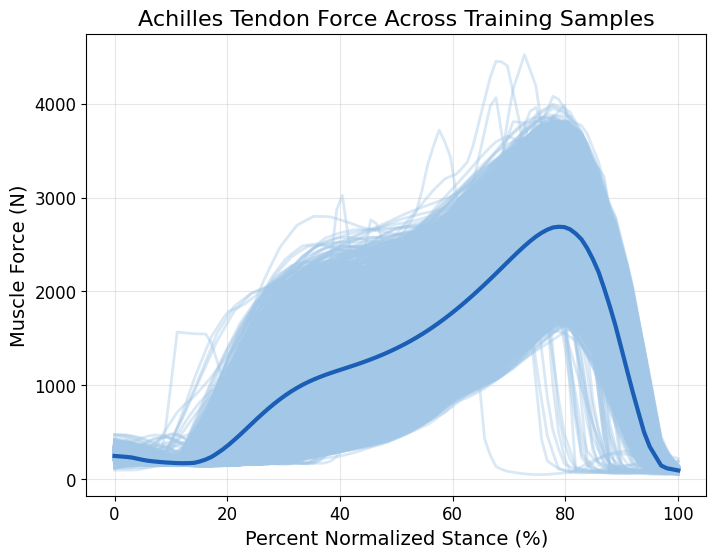

In [4]:
# plot data to double check
plot_achilles_force(y_train)

### Initialize model

In [5]:
# model parameters
input_size = 3           # grf features (x, y, z)
hidden_size = 64         # hidden size for LSTM (tunable)
num_layers = 2           # number of LSTM layers
num_heads = 4            # number of heads for multi-head attention
output_size = 9          # muscle force features
dropout = 0.1            # dropout rate

model = LSTMAttentionModel(input_size, hidden_size, num_layers, num_heads, output_size, dropout)

In [6]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [7]:
# move the model to the device
model.to(device)

LSTMAttentionModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

### Initialize hyperparameters and data loaders

In [8]:
# hyperparameters
num_epochs = 1000
learning_rate = 1e-3
batch_size = 32

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### Train model

In [ ]:
best_model, best_val, train_hist = train_model(model, train_loader, val_loader, num_epochs=num_epochs, learning_rate=learning_rate, patience=10)

Epoch [1/1000], Train Loss: 107594.2190, Val Loss: 50612.1256
Epoch [10/1000], Train Loss: 5505.1166, Val Loss: 4837.5610
Epoch [20/1000], Train Loss: 3623.0704, Val Loss: 3446.0871
Epoch [30/1000], Train Loss: 2862.3035, Val Loss: 2686.0037
Epoch [40/1000], Train Loss: 2455.8281, Val Loss: 2476.7005
Epoch [50/1000], Train Loss: 2163.1661, Val Loss: 3063.2589
Epoch [60/1000], Train Loss: 2038.1182, Val Loss: 2515.7319
Epoch [70/1000], Train Loss: 1897.5509, Val Loss: 1864.0053
Epoch [80/1000], Train Loss: 1713.0422, Val Loss: 1676.8708
Epoch [90/1000], Train Loss: 1739.7967, Val Loss: 1992.1119
Epoch [100/1000], Train Loss: 1634.6841, Val Loss: 1699.2819
Epoch [110/1000], Train Loss: 1481.5496, Val Loss: 1476.7140
Epoch [120/1000], Train Loss: 1447.8181, Val Loss: 1622.2797
Epoch [130/1000], Train Loss: 1404.1825, Val Loss: 1441.6755
Epoch [140/1000], Train Loss: 1330.4680, Val Loss: 1429.5194
Early stopping at epoch 147


### Test model

In [10]:
test_loss, test_outputs, y_test_tensor = evaluate_model(best_model, X_test, y_test, device=device)

Test Loss: 1466.1877


### Plot sample prediction

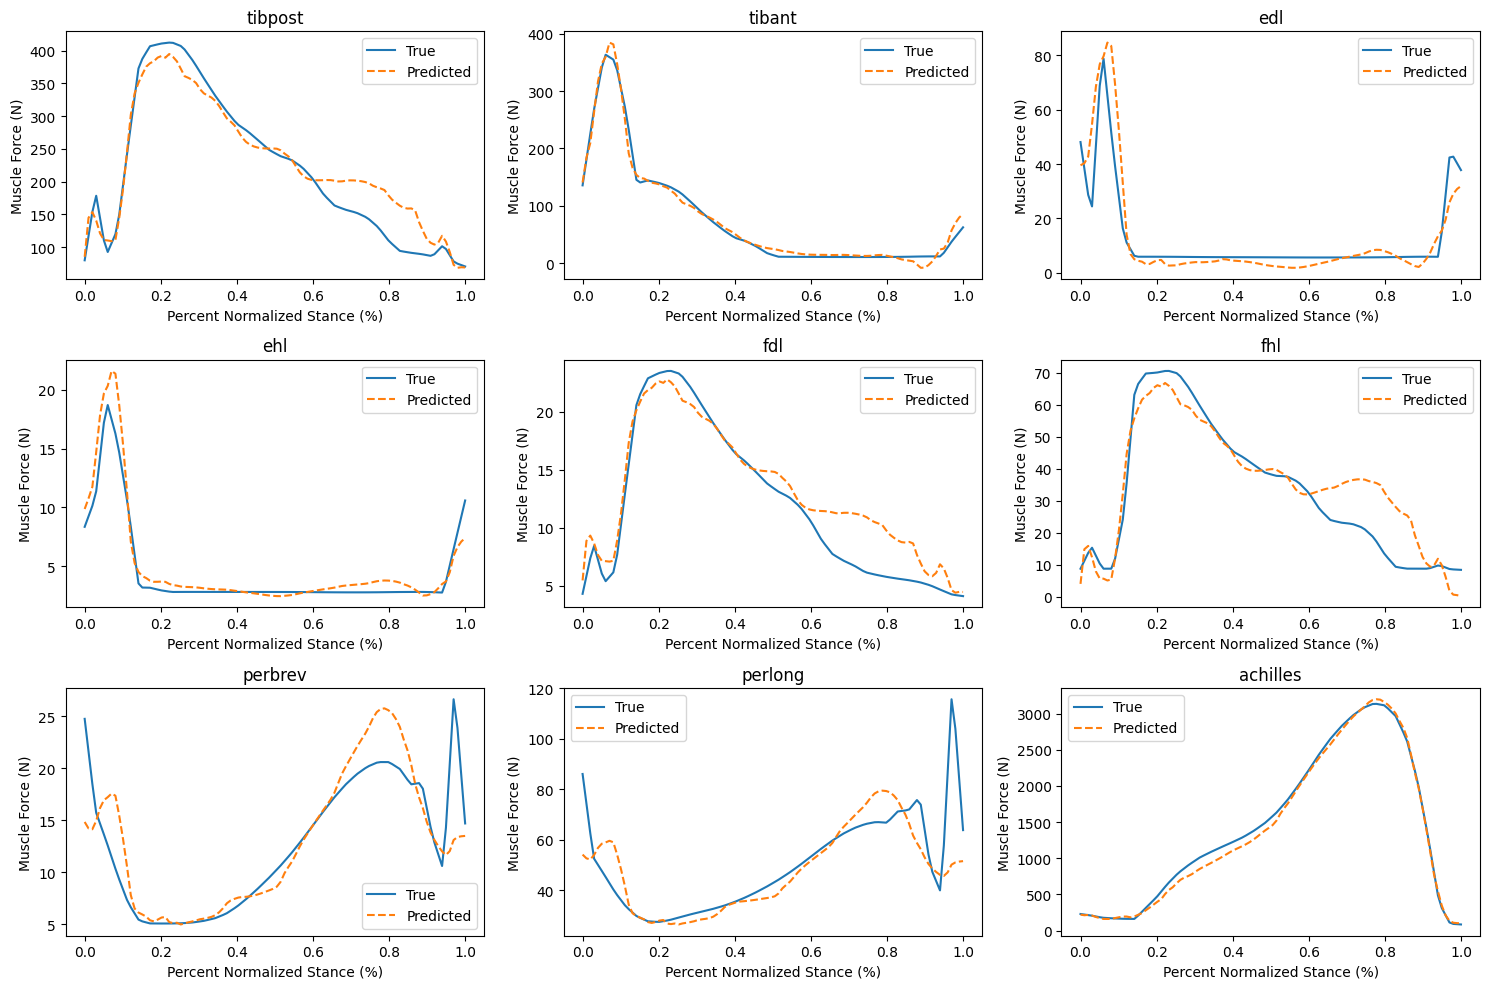

In [11]:
plot_preds(test_outputs, y_test_tensor, sample_idx=0)